# 5. Creating a new classifier in CapyMOA

In this tutorial we show how simple it is to create a new learner in capymoa using Python.

* We choose to make an implementation of the canonical ensemble classifier Online Bagging (AKA OzaBag)
* The base learner is a capymoa object, which allows us to use either SKLearn algorithms or MOA algorithms, thus even though it will be all implemented in Python by us, it can be quite efficient in terms of run time as it depends on the base learner. 


Reference: _Online bagging and boosting._ Oza, Nikunj C., and Stuart J. Russell. In International Workshop on Artificial Intelligence and Statistics, pp. 229-236. PMLR, 2001.

---

*More information about CapyMOA can be found in* https://www.capymoa.org

**last update on 27/07/2024**

## 1. Creating the classifier

* The first step is to extend the `Classifier` abstract class from `capymoa.base` and implement the required methods
  * ```__init__(self, schema=None, random_seed=1, ...)```
  * ```train(self, instance)```
  * ```predict(self, instance)```
  * ```predict_proba(self, instance)```
 
* There is no need to pay much attention to the auxiliary function `poisson`, even though it is a defining characteristic of Online Bagging algorithm but not that relevant for our example

* We specify the parameter `base_learner_class` as a class identifier and proceed to instantiate it inside the init method
```python
        self.ensemble = []
        for i in range(self.ensemble_size): 
            self.ensemble.append(self.base_learner_class(schema=self.schema))
```

In [1]:
# This cell is hidden on capymoa.org. See docs/contributing/docs.rst
from util.nbmock import mock_datasets, is_nb_fast

if is_nb_fast():
    mock_datasets()

In [2]:
from capymoa.base import Classifier
from capymoa.classifier import HoeffdingTree

from collections import Counter
import numpy as np
import random
import math


# Generates a random sample from a Poisson distribution with a given mean parameter `lambd`
def poisson(lambd, random_generator):
    if lambd < 100.0:
        product = 1.0
        _sum = 1.0
        threshold = random_generator.random() * math.exp(lambd)
        i = 1
        max_val = max(100, 10 * math.ceil(lambd))
        while i < max_val and _sum <= threshold:
            product *= lambd / i
            _sum += product
            i += 1
        return i - 1
    x = lambd + math.sqrt(lambd) * random_generator.gauss(0, 1)
    if x < 0.0:
        return 0
    return int(math.floor(x))


# Online Bagging Implementation
class CustomOnlineBagging(Classifier):
    def __init__(
        self, schema=None, random_seed=1, ensemble_size=5, base_learner_class=None
    ):
        super().__init__(schema=schema, random_seed=random_seed)

        self.random_generator = random.Random()

        self.ensemble_size = ensemble_size
        self.base_learner_class = base_learner_class

        if self.base_learner_class is None:
            self.base_learner_class = HoeffdingTree

        self.ensemble = []
        for i in range(self.ensemble_size):
            self.ensemble.append(self.base_learner_class(schema=self.schema))

    def __str__(self):
        return "CustomOnlineBagging"

    def train(self, instance):
        for i in range(self.ensemble_size):
            k = poisson(1.0, self.random_generator)
            for _ in range(k):
                self.ensemble[i].train(instance)

    def predict(self, instance):
        predictions = []
        for i in range(self.ensemble_size):
            predictions.append(self.ensemble[i].predict(instance))
        majority_vote = Counter(predictions)
        prediction = majority_vote.most_common(1)[0][0]
        return prediction

    def predict_proba(self, instance):
        probabilities = []
        for i in range(self.ensemble_size):
            classifier_proba = self.ensemble[i].predict_proba(instance)
            classifier_proba = classifier_proba / np.sum(classifier_proba)
            probabilities.append(classifier_proba)
        avg_proba = np.mean(probabilities, axis=0)
        return avg_proba

## 3. Evaluating the classifier

* We use the same approach as when we evaluate any other capymoa learner.
* We show how it is simple to use learners with different backends in our implementation, e.g.
    * `HoeffdingTree` (MOA)
    * `SGDClassifier` (SKLearn)

CustomOnlineBagging(HT) accuracy: 82.84339689265536, wallclock: 4.093186378479004


CustomOnlineBagging(SGD) accuracy: 82.21663135593221, wallclock: 3.690402030944824


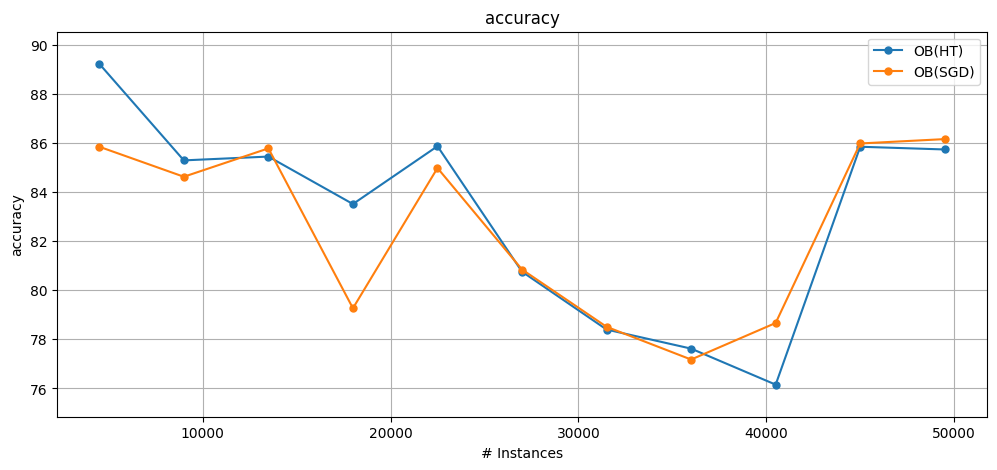

In [3]:
from capymoa.evaluation import prequential_evaluation
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.datasets import Electricity
from capymoa.classifier import SGDClassifier

elec_stream = Electricity()

# Creating a learner: using a hoeffding adaptive tree as the base learner
ob_ht = CustomOnlineBagging(
    schema=elec_stream.get_schema(), ensemble_size=5, base_learner_class=HoeffdingTree
)
ob_sgd = CustomOnlineBagging(
    schema=elec_stream.get_schema(), ensemble_size=5, base_learner_class=SGDClassifier
)

results_ob_ht = prequential_evaluation(
    stream=elec_stream, learner=ob_ht, window_size=4500
)
print(
    f"CustomOnlineBagging(HT) accuracy: {results_ob_ht.cumulative.accuracy()}, wallclock: {results_ob_ht.wallclock()}"
)
results_ob_sgd = prequential_evaluation(
    stream=elec_stream, learner=ob_ht, window_size=4500
)
print(
    f"CustomOnlineBagging(SGD) accuracy: {results_ob_sgd.cumulative.accuracy()}, wallclock: {results_ob_sgd.wallclock()}"
)

results_ob_ht.learner = "OB(HT)"
results_ob_sgd.learner = "OB(SGD)"
plot_windowed_results(results_ob_ht, results_ob_sgd, metric="accuracy")

## 4. CustomOnlineBagging and OnlineBagging

* Testing and training our custom online bagging implementation alongside the online bagging implementation from `capymoa.classifier.OnlineBagging`.

In [4]:
%%time
from capymoa.classifier import OnlineBagging
from capymoa.evaluation import ClassificationEvaluator
from capymoa.datasets import RBFm_100k

RBFm_100k_stream = RBFm_100k()

# Creating a learner without specifying the base_learner thus HoeffdingTree is used
custom_ob = CustomOnlineBagging(schema=RBFm_100k_stream.get_schema(), ensemble_size=5)
capy_ob = OnlineBagging(schema=RBFm_100k_stream.get_schema(), ensemble_size=5)

custom_ob_evaluator = ClassificationEvaluator(schema=RBFm_100k_stream.get_schema())
capy_ob_evaluator = ClassificationEvaluator(schema=RBFm_100k_stream.get_schema())

while RBFm_100k_stream.has_more_instances():
    instance = RBFm_100k_stream.next_instance()

    prediction_new = custom_ob.predict(instance)
    prediction = capy_ob.predict(instance)

    custom_ob_evaluator.update(instance.y_index, prediction_new)
    capy_ob_evaluator.update(instance.y_index, prediction)

    custom_ob.train(instance)
    capy_ob.train(instance)

print(f"[custom] Online Bagging acc: {custom_ob_evaluator.accuracy()}")
print(f"[capymoa] Online Bagging acc: {capy_ob_evaluator.accuracy()}")

[custom] Online Bagging acc: 67.611
[capymoa] Online Bagging acc: 60.357000000000006
CPU times: user 11.6 s, sys: 31.4 ms, total: 11.7 s
Wall time: 10.3 s
